In [25]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Thiết lập hiển thị
sns.set_theme(style="whitegrid")

# 2. Định nghĩa đường dẫn
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'brussels')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)

# 3. Đọc các file KPI đã tính toán từ File 02
CITY_SUFFIX = 'brussels'

try:
    # Đọc file Supply
    kpi_supply = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_supply_{CITY_SUFFIX}.csv'))
    
    # Đọc file Price
    kpi_price = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_price_{CITY_SUFFIX}.csv'))
    
    # Đọc file Room Type
    kpi_room = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_room_type_{CITY_SUFFIX}.csv'))
    
    print("✅ Đã nạp thành công 3 bảng KPI.")
    
    # --- XỬ LÝ SẮP XẾP THỜI GIAN ---
    # Vì đọc từ CSV lên, python hiểu ngày tháng là chuỗi, ta cần chuyển lại thành datetime để vẽ biểu đồ đúng thứ tự
    def sort_by_date(df):
        df['snapshot_datetime'] = pd.to_datetime(df['snapshot_date'])
        return df.sort_values('snapshot_datetime')

    kpi_supply = sort_by_date(kpi_supply)
    kpi_price = sort_by_date(kpi_price)
    # Với room type, ta cần mẹo một chút để sắp xếp khi vẽ
    kpi_room['snapshot_datetime'] = pd.to_datetime(kpi_room['snapshot_date'])
    kpi_room = kpi_room.sort_values('snapshot_datetime')
    
    print("✅ Đã sắp xếp dữ liệu theo thời gian (Quá khứ -> Tương lai).")
    
except FileNotFoundError:
    print("❌ LỖI: Không tìm thấy file KPI. Hãy chắc chắn bạn đã chạy xong File 02!")

✅ Đã nạp thành công 3 bảng KPI.
✅ Đã sắp xếp dữ liệu theo thời gian (Quá khứ -> Tương lai).


--- BẮT ĐẦU VẼ 6 BIỂU ĐỒ (OUTPUT: PDF) ---
✅ Đã nạp KPI tóm tắt.
✅ Đã nạp dữ liệu chi tiết từ snapshot 21 June, 2025 (6721 dòng).


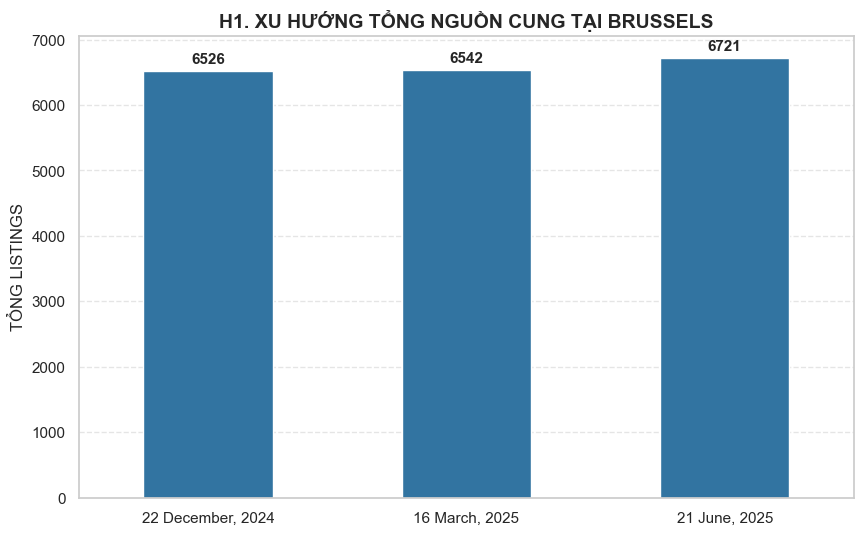

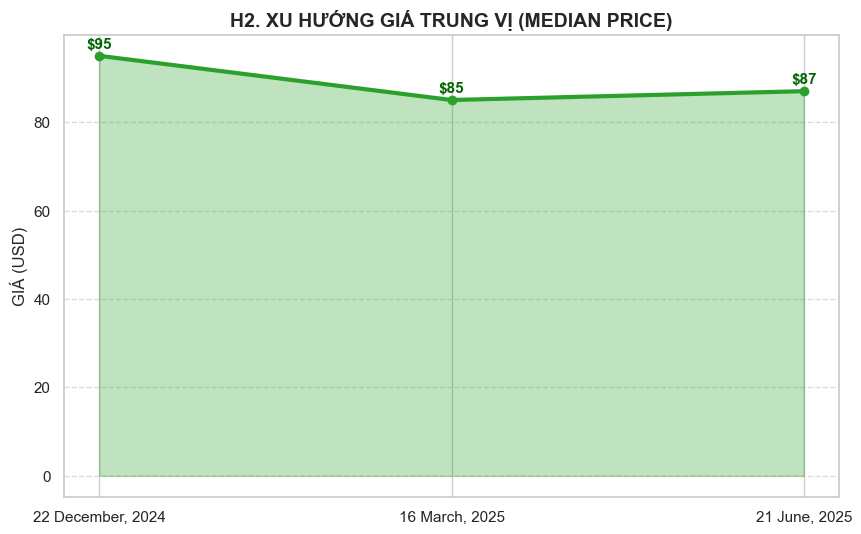

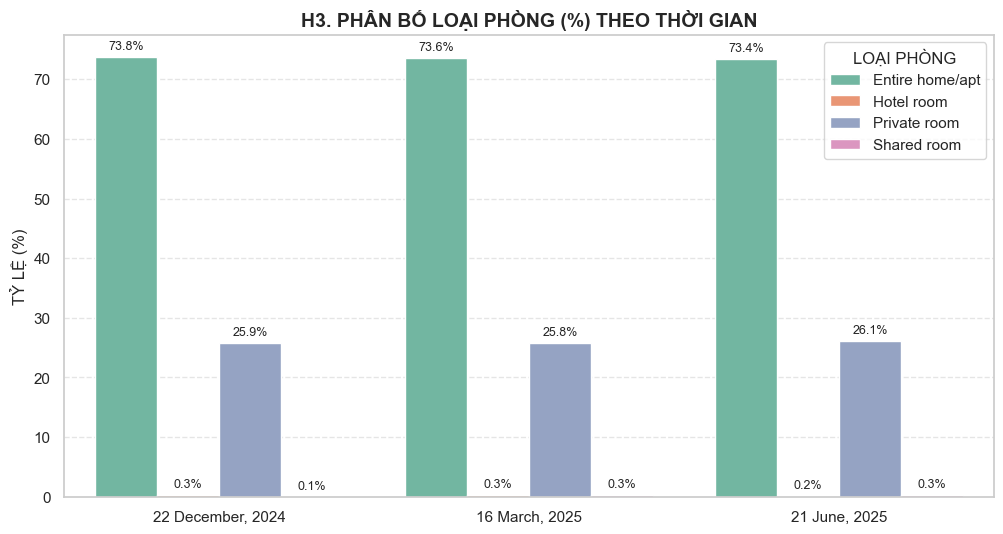

C:\Users\Admin\AppData\Local\Temp\ipykernel_6256\3100178285.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=neigh_price, y='neighbourhood_cleansed', x='price_numeric', palette='Reds_r')


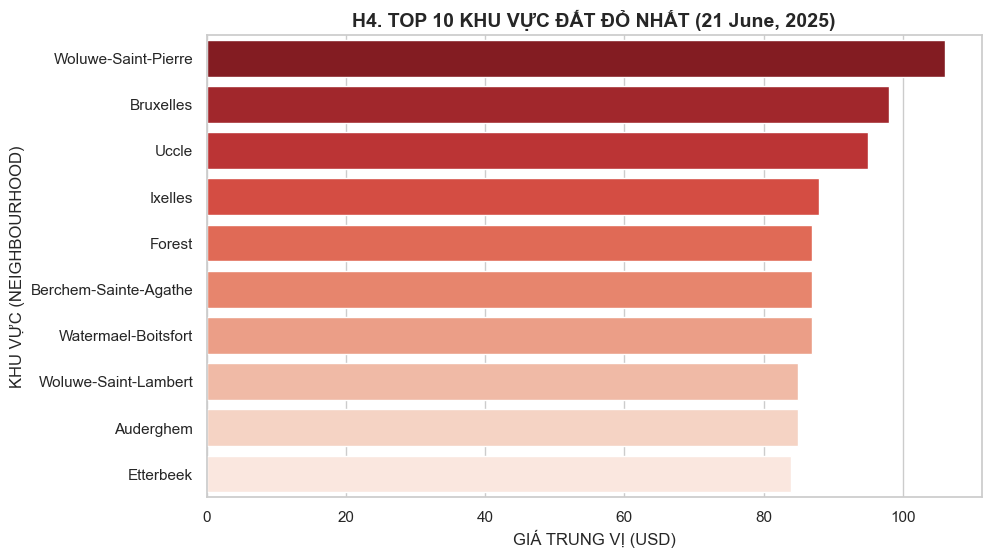

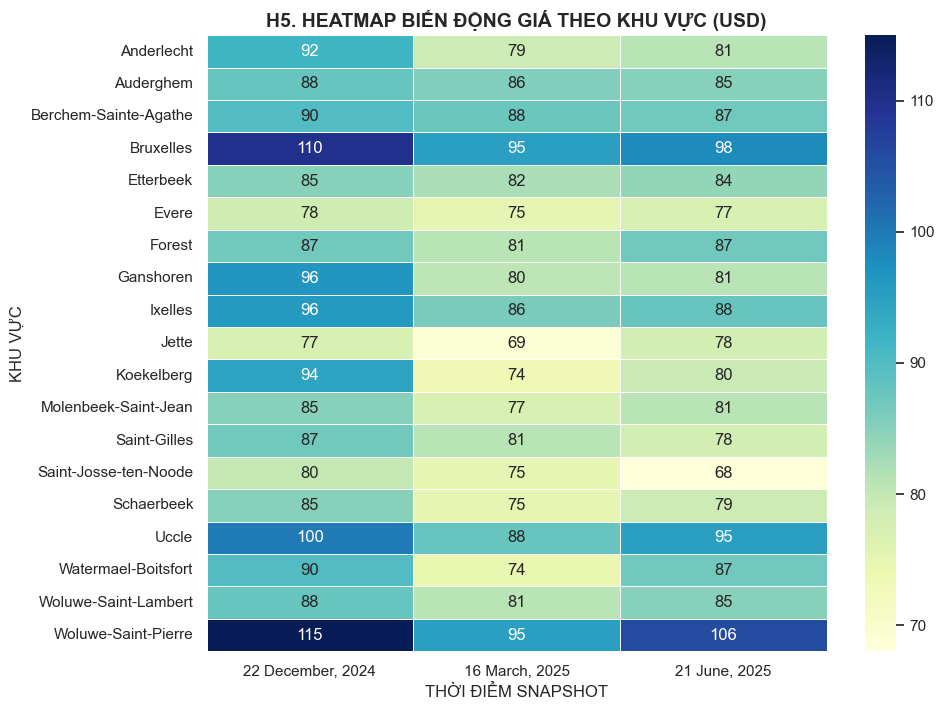

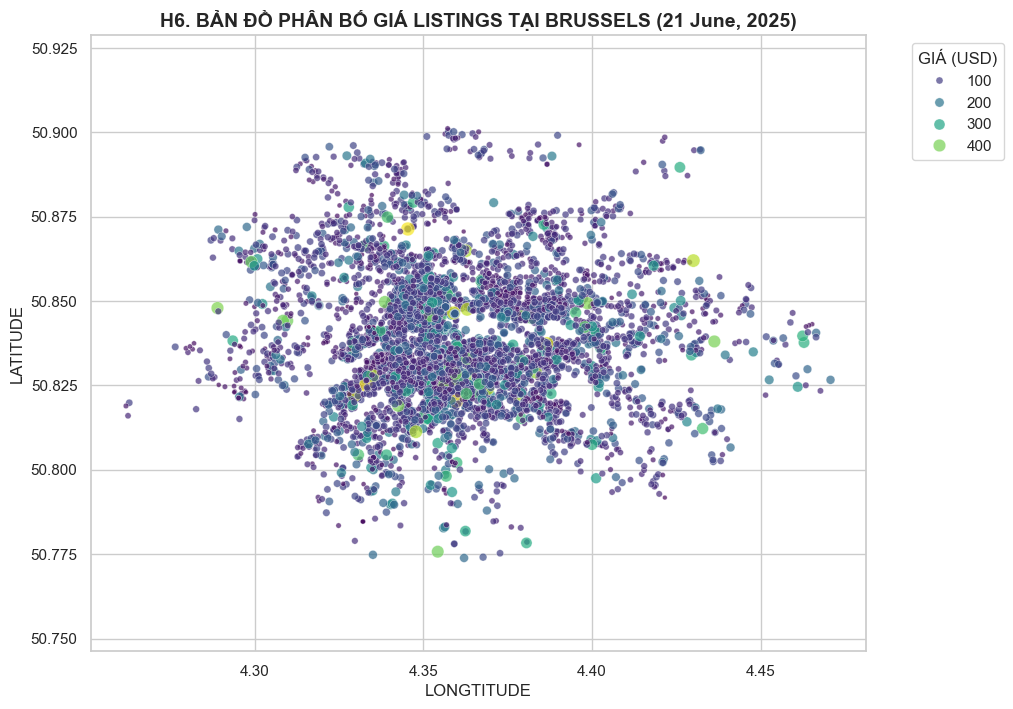


🎉 HOÀN TẤT 6 HÌNH! Kiểm tra thư mục '..\figures' để lấy file PDF.


In [26]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. THIẾT LẬP ---
sns.set_theme(style="whitegrid")
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'brussels')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)
CITY_SUFFIX = 'brussels'

print("--- BẮT ĐẦU VẼ 6 BIỂU ĐỒ (OUTPUT: PDF) ---")

# --- 2. NẠP DỮ LIỆU ---

# A. Nạp KPI tóm tắt (Cho hình 1, 2, 3)
try:
    kpi_supply = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_supply_{CITY_SUFFIX}.csv'))
    kpi_price = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_price_{CITY_SUFFIX}.csv'))
    kpi_room = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_room_type_{CITY_SUFFIX}.csv'))
    
    # Sắp xếp thời gian
    def sort_dates(df):
        df['dt'] = pd.to_datetime(df['snapshot_date'])
        return df.sort_values('dt').drop(columns=['dt'])
    
    kpi_supply = sort_dates(kpi_supply)
    kpi_price = sort_dates(kpi_price)
    # kpi_room xử lý sau
    print("✅ Đã nạp KPI tóm tắt.")
except:
    print("❌ Thiếu file KPI. Hãy chạy File 02 trước.")

# B. Nạp Dữ liệu chi tiết (Cho hình 4, 5, 6 - Cần Lat/Lon và Neighbourhood)
# Chúng ta lấy snapshot MỚI NHẤT để vẽ bản đồ
LATEST_SNAPSHOT = '21 June, 2025' # Thay đổi nếu tên thư mục của bạn khác
latest_file = os.path.join(PROCESSED_DIR, LATEST_SNAPSHOT, 'listings_processed.csv')

if os.path.exists(latest_file):
    df_detail = pd.read_csv(latest_file, low_memory=False)
    print(f"✅ Đã nạp dữ liệu chi tiết từ snapshot {LATEST_SNAPSHOT} ({len(df_detail)} dòng).")
else:
    print(f"❌ Không tìm thấy snapshot {LATEST_SNAPSHOT} để vẽ bản đồ.")


# --- 3. VẼ BIỂU ĐỒ ---

# === HÌNH 1: Xu hướng Nguồn Cung (Bar Chart) ===
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=kpi_supply, x='snapshot_date', y='total_listings', color='#1f77b4', width=0.5)
plt.title('H1. XU HƯỚNG TỔNG NGUỒN CUNG TẠI BRUSSELS', fontsize=14, fontweight='bold')
plt.ylabel('TỔNG LISTINGS')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
for i in ax1.containers: ax1.bar_label(i, padding=3, fontsize=11, fontweight='bold')
plt.savefig(os.path.join(FIGURES_DIR, 'brussels_01_supply.pdf'), format='pdf', bbox_inches='tight')
plt.show()

# === HÌNH 2: Xu hướng Giá (Area Chart) ===
plt.figure(figsize=(10, 6))
plt.plot(kpi_price['snapshot_date'], kpi_price['median_price'], marker='o', linewidth=3, color='#2ca02c')
plt.fill_between(kpi_price['snapshot_date'], kpi_price['median_price'], color='#2ca02c', alpha=0.3)
plt.title('H2. XU HƯỚNG GIÁ TRUNG VỊ (MEDIAN PRICE)', fontsize=14, fontweight='bold')
plt.ylabel('GIÁ (USD)')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for x, y in zip(kpi_price['snapshot_date'], kpi_price['median_price']):
    plt.text(x, y + 1, f"${y:.0f}", ha='center', va='bottom', fontsize=11, fontweight='bold', color='darkgreen')
plt.savefig(os.path.join(FIGURES_DIR, 'brussels_02_price.pdf'), format='pdf', bbox_inches='tight')
plt.show()

# === HÌNH 3: Cơ cấu Loại phòng (Grouped Bar) ===
plt.figure(figsize=(12, 6))
# Reindex room type theo time
kpi_room['dt'] = pd.to_datetime(kpi_room['snapshot_date'])
kpi_room = kpi_room.sort_values('dt')
ax3 = sns.barplot(data=kpi_room, x='snapshot_date', y='percentage', hue='room_type', palette='Set2')
plt.title('H3. PHÂN BỐ LOẠI PHÒNG (%) THEO THỜI GIAN', fontsize=14, fontweight='bold')
plt.ylabel('TỶ LỆ (%)')
plt.xlabel('')
plt.legend(title='LOẠI PHÒNG', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.5)
for i in ax3.containers: ax3.bar_label(i, fmt='%.1f%%', padding=3, fontsize=9)
plt.savefig(os.path.join(FIGURES_DIR, 'brussels_03_room_type.pdf'), format='pdf', bbox_inches='tight')
plt.show()

# === HÌNH 4: Top 10 Khu vực Đắt đỏ nhất (Bar Chart) ===
# Tính giá trung vị theo khu vực (từ snapshot mới nhất)
neigh_price = df_detail.groupby('neighbourhood_cleansed')['price_numeric'].median().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=neigh_price, y='neighbourhood_cleansed', x='price_numeric', palette='Reds_r')
plt.title(f'H4. TOP 10 KHU VỰC ĐẮT ĐỎ NHẤT ({LATEST_SNAPSHOT})', fontsize=14, fontweight='bold')
plt.xlabel('GIÁ TRUNG VỊ (USD)')
plt.ylabel('KHU VỰC (NEIGHBOURHOOD)')
plt.savefig(os.path.join(FIGURES_DIR, 'brussels_04_top10_price.pdf'), format='pdf', bbox_inches='tight')
plt.show()

# === HÌNH 5: Heatmap Giá theo Khu vực (Advanced) ===
# Chúng ta cần load lại tất cả snapshot chi tiết để làm heatmap này
# (Đoạn này hơi nâng cao, ta dùng pivot table)
all_files = glob.glob(os.path.join(PROCESSED_DIR, '*', 'listings_processed.csv'))
df_list = []
for f in all_files:
    s_name = os.path.basename(os.path.dirname(f))
    d = pd.read_csv(f, usecols=['neighbourhood_cleansed', 'price_numeric']) # Chỉ đọc 2 cột cho nhẹ
    d['snapshot'] = s_name
    df_list.append(d)
df_heatmap_src = pd.concat(df_list)

# Chỉ lấy Top 15 khu vực có nhiều listing nhất để heatmap đỡ rối
top_neighs = df_heatmap_src['neighbourhood_cleansed'].value_counts().head(19).index
df_heatmap_src = df_heatmap_src[df_heatmap_src['neighbourhood_cleansed'].isin(top_neighs)]

# Tạo Pivot Table: Index=Khu vực, Columns=Thời gian, Values=Giá Median
heatmap_data = df_heatmap_src.groupby(['neighbourhood_cleansed', 'snapshot'])['price_numeric'].median().unstack()
# Sắp xếp cột thời gian (Mẹo: chuyển về datetime sort rồi chuyển lại)
cols = sorted(heatmap_data.columns, key=pd.to_datetime)
heatmap_data = heatmap_data[cols]

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5)
plt.title('H5. HEATMAP BIẾN ĐỘNG GIÁ THEO KHU VỰC (USD)', fontsize=14, fontweight='bold')
plt.xlabel('THỜI ĐIỂM SNAPSHOT')
plt.ylabel('KHU VỰC')
plt.savefig(os.path.join(FIGURES_DIR, 'brussels_05_price_heatmap.pdf'), format='pdf', bbox_inches='tight')
plt.show()

# === HÌNH 6: Bản đồ Phân bố Listing (Geospatial Scatter Plot) ===
plt.figure(figsize=(10, 8))
# Lọc bớt giá quá cao để màu sắc hiển thị rõ hơn (vmax=200)
sns.scatterplot(
    data=df_detail[df_detail['price_numeric'] < 500], 
    x='longitude', y='latitude', 
    hue='price_numeric', palette='viridis', 
    size='price_numeric', sizes=(10, 100), alpha=0.7
)
plt.title(f'H6. BẢN ĐỒ PHÂN BỐ GIÁ LISTINGS TẠI BRUSSELS ({LATEST_SNAPSHOT})', fontsize=14, fontweight='bold')
plt.xlabel('LONGTITUDE')
plt.ylabel('LATITUDE')
plt.legend(title='GIÁ (USD)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal') # Giữ tỉ lệ bản đồ chuẩn
plt.savefig(os.path.join(FIGURES_DIR, 'brussels_06_map.pdf'), format='pdf', bbox_inches='tight')
plt.show()

print(f"\n🎉 HOÀN TẤT 6 HÌNH! Kiểm tra thư mục '{FIGURES_DIR}' để lấy file PDF.")